# Отток клиентов

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.<br><br>
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.<br><br>
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.<br><br>
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

## Описание данных

Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»).
<br><br><strong>Признаки</strong>
<br><br><em>RowNumber</em> — индекс строки в данных
<br><em>CustomerId</em> — уникальный идентификатор клиента
<br><em>Surname</em> — фамилия
<br><em>CreditScore</em> — кредитный рейтинг
<br><em>Geography</em> — страна проживания
<br><em>Gender</em> — пол
<br><em>Age</em> — возраст
<br><em>Tenure</em> — сколько лет человек является клиентом банка
<br><em>Balance</em> — баланс на счёте
<br><em>NumOfProducts</em> — количество продуктов банка, используемых клиентом
<br><em>HasCrCard</em> — наличие кредитной карты
<br><em>IsActiveMember</em> — активность клиента
<br><em>EstimatedSalary</em> — предполагаемая зарплата
<br><br><strong>Целевой признак</strong>
<br><br><em>Exited</em> — факт ухода клиента


# Изучение данных из файла & предварительная подготовка

## Импорт библиотек

In [1]:
import pandas as pd
import os
import numpy as np
import re

from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('seaborn-deep')
%matplotlib inline

## Откроем локальную или веб-версию файла данных

Напишем функцию поиска файла на локальном диске или в сети;
<br>После того как файл найден, прочтем его, получив детальную сводку.

In [2]:
def find(name, path):
    '''
    Function to find the data file stored locally.
    Takes name of the file and root directory.
    Scanes the local directory tree for the first orrurance of the file.
    '''
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)


online_path = 'datasets'
offline_path = '/home/'
file = 'Churn.csv'

try:
    df = pd.read_csv(f'/{online_path}/{file}', index_col='RowNumber')
except FileNotFoundError:
    df = pd.read_csv(find(file, offline_path), index_col='RowNumber')
    print(f"Файл {file} найден на локальном диске.")
else:
    print(f"Файл {file} открыт в режиме online.")

Файл Churn.csv открыт в режиме online.


In [3]:
start = "\033[1m"
end = "\033[0;0m"
print(
    f"Внешний вид первых пяти строк датафрейма {start}{str(file).split('.')[0].upper()}{end}:"
)
display(df.head())
print()
print(f"Размер датафрейма {start}{str(file).split('.')[0].upper()}{end}: \
        \nколичество строк - {df.shape[0]}, \nколичество столбцов - {df.shape[1]}."
      )
print()
print(
    f"Развернутая сводка датафрейма {start}{str(file).split('.')[0].upper()}{end} \nпо наименованию столбцов, типу данных, ненулевых значениях и объему памяти:"
)
print()
df.info(memory_usage='deep')
print('--------------------------------------------------------------------')
print()

Внешний вид первых пяти строк датафрейма CHURN:


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.00,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.00,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.00,125510.82,1,1,1,79084.10,0



Размер датафрейма CHURN:         
количество строк - 10000, 
количество столбцов - 13.

Развернутая сводка датафрейма CHURN 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 2.6 MB
--------------------------------------------------------------------



### _Промежуточные выводы_

1. Наименование столбцов и индекса в стиле CamelCase --> перевести в snake_case. 
2. Столбец **Tenure** имеет пропуски --> выяснить причину и возможные пути устранения. 
3. Столбец **Tenure** представлен в виде вещественного числа --> перевести в цельночисленное после обработки пропусков.
4. Проверим уникальность значений столбца customer_id.

## Обработка стиля наименования столбцов

In [4]:
df.columns = [
    re.sub(r'(?<!^)(?=[A-Z])', '_', column_name).lower()
    for column_name in df.columns
]

In [5]:
df.index.rename(re.sub(r'(?<!^)(?=[A-Z])', '_', df.index.name).lower(),
                inplace=True)

In [6]:
# проверим полученный результат: 
df.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
row_number,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.00,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.00,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.00,125510.82,1,1,1,79084.10,0


## Обработка пропусков столбца **TENURE**

In [7]:
# рассмотрим все возможные значения столбца Tenure: 
df.tenure.value_counts()

1.00     952
2.00     950
8.00     933
3.00     928
5.00     927
7.00     925
4.00     885
9.00     882
6.00     881
10.00    446
0.00     382
Name: tenure, dtype: int64

### _Промежуточные выводы_

Так как в данном столбце собраны данные о количестве лет, в течение которых человек является клиентом банка, и значения в столбце от 0 до 10 лет, то данный столбец можно принять за категориальный и разбить его на столбцы методом ОНЕ. Таким образом, алгоритм сможет использовать в том числе и те данные, которые содержат пропуски. Обработка формата числа столбца **Tenure** теряет смысл.  

## Обработка значений столбца **CUSTOMER_ID**

In [8]:
# вычтем количество уникальных значений из общего числа значений
df.customer_id.size - df.customer_id.nunique()

0

### _Промежуточные выводы_

Все значения столбца **customer_id** уникальны. Таким образом, для первичной тренировки моделей потребуется отбросить нечисловые столбцы, включая **customer_id** и преобразовать столбец **tenure** методом OHE. 

## OHE для столбца **TENURE**

In [9]:
#  применим метод OHE к столбцу tenure: 
tenure_ohe = pd.get_dummies(df['tenure'], prefix='tenure_', dummy_na=True)

In [10]:
# рассмотрим полученный результат: 
tenure_ohe.head()

,tenure__0.0,tenure__1.0,tenure__2.0,tenure__3.0,tenure__4.0,tenure__5.0,tenure__6.0,tenure__7.0,tenure__8.0,tenure__9.0,tenure__10.0,tenure__nan
row_number,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0


In [11]:
# удалим столбец tenure из датафрейма: 
df_modified = df.drop('tenure', axis=1)

In [12]:
# объединим оба датафрейма: 
df_modified = df_modified.join(tenure_ohe)

In [13]:
# удалим последний столбец, чтобы избежать dummy-ловушки: 
df_modified.drop('tenure__nan', axis=1, inplace=True)

## Подготовка датафрейма для разделения данных

In [14]:
# отбросим текстовые столбцы и столбец customer_id: 
df_raw_numeric = df_modified.drop(['customer_id', 'surname', 'geography', 'gender'], axis=1)

In [15]:
# рассмотрим полученный датафрейм: 
df_raw_numeric.head()

,credit_score,age,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure__0.0,tenure__1.0,tenure__2.0,tenure__3.0,tenure__4.0,tenure__5.0,tenure__6.0,tenure__7.0,tenure__8.0,tenure__9.0,tenure__10.0
row_number,,,,,,,,,,,,,,,,,,,
1,619,42,0.00,1,1,1,101348.88,1,0,0,1,0,0,0,0,0,0,0,0
2,608,41,83807.86,1,0,1,112542.58,0,0,1,0,0,0,0,0,0,0,0,0
3,502,42,159660.80,3,1,0,113931.57,1,0,0,0,0,0,0,0,0,1,0,0
4,699,39,0.00,2,0,0,93826.63,0,0,1,0,0,0,0,0,0,0,0,0
5,850,43,125510.82,1,1,1,79084.10,0,0,0,1,0,0,0,0,0,0,0,0


# Подготовка данных для построения модели

## Извлечем признаки и целевой признак

In [16]:
# признаки = все столбцы, кроме exited:
features = df_raw_numeric.drop("exited", axis=1)

In [17]:
# целевой признак - столбец exited:
target = df_raw_numeric.exited

## Разделение данных

In [18]:
# выделим данные для обучения: 
features_train, features_1, target_train, target_1 = train_test_split(
    features, target, test_size=0.4, random_state=12345)

In [19]:
# выделим данные для валидации и тестирования:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_1, target_1, test_size=0.5, random_state=12345)

# Обучение моделей на исходных данных

## Модель - Логистическая регрессия

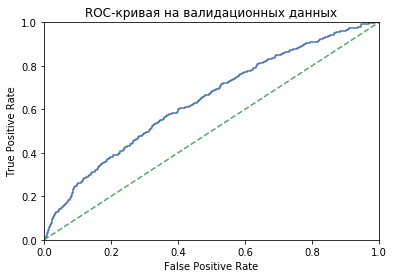

Accuracy модели логистической регрессии на валидационной выборке: 0.787 
F1 result:  0.13414634146341464 
AUC-ROC:  0.6404085921888374
CPU times: user 255 ms, sys: 124 ms, total: 379 ms
Wall time: 390 ms


In [20]:
%%time
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid)
f1_result = f1_score(target_valid, model.predict(features_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1] 
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая на валидационных данных')
plt.show()

print("Accuracy модели логистической регрессии на валидационной выборке:",
      result, '\nF1 result: ', f1_result, '\nAUC-ROC: ', auc_roc)

## Модель - Дерево решений

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


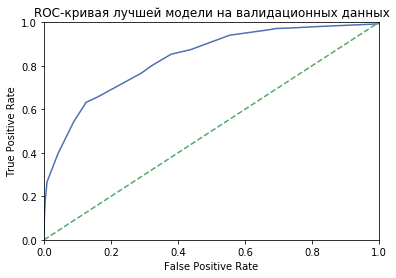

F1 наилучшей модели "Дерево решений" на валидационной выборке: 0.5114155251141553 
AUC-ROC:  0.8339247246544972 
Depth:  5 
Criterion:  entropy
CPU times: user 417 ms, sys: 840 µs, total: 418 ms
Wall time: 425 ms


In [21]:
%%time
best_model = None
best_result = 0
best_depth = 0
best_auc = 0
criterions = ['gini', 'entropy']

for criterion in criterions:
    for x in range(1, 10):
        model = DecisionTreeClassifier(random_state=12345,
                                       max_depth=x,
                                       criterion=criterion)
        model.fit(features_train, target_train)
        f1_result = f1_score(target_valid, model.predict(features_valid))
        probabilities_valid = model.predict_proba(features_valid)
        auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])
        if f1_result > best_result:
            best_depth = x
            best_model = model
            best_result = f1_result
            best_criterion = criterion
            best_auc = auc_roc

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая лучшей модели на валидационных данных')
plt.show()

print('F1 наилучшей модели "Дерево решений" на валидационной выборке:',
      best_result, '\nAUC-ROC: ', best_auc, '\nDepth: ', best_depth,
      '\nCriterion: ', best_criterion)

In [22]:
# получим развернутый отчет о качестве работы модели:
print(
    classification_report(target_valid,
                          best_model.predict(features_valid),
                          target_names=['not excited', 'excited']))

              precision    recall  f1-score   support

 not excited       0.86      0.96      0.90      1577
     excited       0.72      0.40      0.51       423

    accuracy                           0.84      2000
   macro avg       0.79      0.68      0.71      2000
weighted avg       0.83      0.84      0.82      2000



In [23]:
# получим развернутый отчет о качестве работы лучшей модели на тестовой выборке:
print(
    classification_report(target_test,
                          best_model.predict(features_test),
                          target_names=['not excited', 'excited']))

              precision    recall  f1-score   support

 not excited       0.87      0.96      0.91      1582
     excited       0.75      0.44      0.55       418

    accuracy                           0.85      2000
   macro avg       0.81      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000



## Модель - Случайный лес

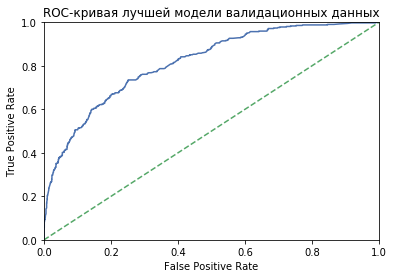

F1 наилучшей модели 'Случайный лес' на валидационной выборке: 0.43812709030100333 
AUC-ROC:  0.7876597843407973 
Depth:  5 
Number of estimators:  8 
Criterion:  gini
CPU times: user 493 ms, sys: 9.64 ms, total: 503 ms
Wall time: 514 ms


In [24]:
%%time
best_model = None
best_result = 0
best_est = 0
best_auc = 0
criterions = ['gini', 'entropy']

for criterion in criterions:
    for est in range(1, 10):
        model = RandomForestClassifier(random_state=12345,
                                       max_depth=5,
                                       criterion=criterion,
                                       n_estimators=est)
        model.fit(features_train, target_train)
        f1_result = f1_score(target_valid, model.predict(features_valid))
        if f1_result > best_result:
            best_est = est
            best_model = model
            best_result = f1_result
            best_criterion = criterion
            best_auc = auc_roc

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая лучшей модели валидационных данных')
plt.show()

print("F1 наилучшей модели 'Случайный лес' на валидационной выборке:",
      best_result, '\nAUC-ROC: ', best_auc, '\nDepth: ', best_depth,
      '\nNumber of estimators: ', best_est, '\nCriterion: ', best_criterion)

In [25]:
# получим развернутый отчет о качестве работы модели:
print(
    classification_report(target_valid,
                          best_model.predict(features_valid),
                          target_names=['not excited', 'excited']))

              precision    recall  f1-score   support

 not excited       0.84      0.97      0.90      1577
     excited       0.75      0.31      0.44       423

    accuracy                           0.83      2000
   macro avg       0.79      0.64      0.67      2000
weighted avg       0.82      0.83      0.80      2000



In [26]:
# получим развернутый отчет о качестве работы лучшей модели на тестовой выборке:
print(
    classification_report(target_test,
                          best_model.predict(features_test),
                          target_names=['not excited', 'excited']))

              precision    recall  f1-score   support

 not excited       0.85      0.98      0.91      1582
     excited       0.80      0.34      0.48       418

    accuracy                           0.85      2000
   macro avg       0.83      0.66      0.70      2000
weighted avg       0.84      0.85      0.82      2000



### _Промежуточные выводы_

Наилучший результат на несбалансированных данных показывает модель **Дерево решений**. Но даже эта модель не позволяет добиться целевого результата в 0,59 для F1. 
 
При этом в виду того, что данные не прошли дополнительной подготовки, точность определения между лояльными и не лояльными клиентами имеет разницу почти в два раза.

# Предварительная подготовка данных для обучения моделей

## Кодирование категориальных данных

In [27]:
# отбросим столбцы customer_id и surname:
df = df.drop(['customer_id', 'surname'], axis=1)

In [28]:
#  применим метод OHE к столбцам датафрейма, содержащим категориальные данные:
df_ohe = pd.get_dummies(
    df,
    columns=['geography', 'gender', 'tenure', 'num_of_products'],
    dummy_na=True,
    drop_first=True)

## Извлечем признаки и целевой признак

In [29]:
# признаки = все столбцы, кроме exited:
features = df_ohe.drop("exited", axis=1)

In [30]:
# целевой признак - столбец exited:
target = df_ohe.exited

## Разделение данных

In [31]:
# выделим данные для обучения с учетом стратификации: 
features_train, features_1, target_train, target_1 = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)

In [32]:
# выделим данные для валидации и тестирования с учетом стратификации:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_1, target_1, test_size=0.5, random_state=12345, stratify=target_1)

## Масштабирование данных

In [33]:
# создадим список столбцов, содержащих числовые значения: 
numeric = ['credit_score', 'age', 'balance', 'estimated_salary']

In [34]:
# стандартизируем числовые данные признаков:  
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

## Увеличение обучающей выборки - upsampling

In [35]:
# рассмотрим разницу в количестве отрицательных и положительных объектов: 
target.value_counts()[0] / target.value_counts()[1]

3.9091801669121256

Так как разница почти 4 раза, создадим функцию для увеличения выборки по отрицательному признаку.

In [36]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [37]:
# вызовем полученную функцию на обучающую выборку: 
features_train, target_train = upsample(features_train, target_train, 4)

# Обучение моделей на категоризированных и стандартизированных данных 

## Модель - Логистическая регрессия

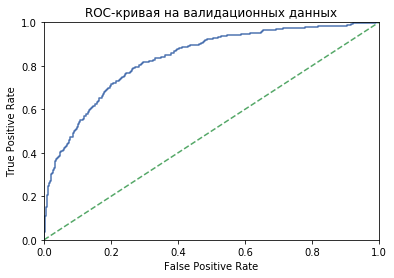

Accuracy модели логистической регрессии на валидационной выборке: 0.749 
F1 result:  0.5549645390070921 
AUC-ROC:  0.8343752072565632
CPU times: user 291 ms, sys: 117 ms, total: 407 ms
Wall time: 424 ms


In [38]:
%%time
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid)
f1_result = f1_score(target_valid, model.predict(features_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1] 
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая на валидационных данных')
plt.show()

print("Accuracy модели логистической регрессии на валидационной выборке:",
      result, '\nF1 result: ', f1_result, '\nAUC-ROC: ', auc_roc)

In [39]:
print(f'Значение метрики F1 на тестовых данных: {f1_score(target_test, model.predict(features_test))}')
print(f'AUC-ROC на тестовых данных: {roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])}')

Значение метрики F1 на тестовых данных: 0.5866177818515124
AUC-ROC на тестовых данных: 0.8440964011232633


## Модель - Дерево решений

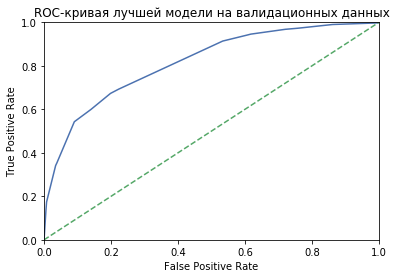

F1 наилучшей модели "Дерево решений" на валидационной выборке: 0.5496489468405217 
AUC-ROC:  0.8164227401515537 
Depth:  4 
Criterion:  entropy
CPU times: user 651 ms, sys: 49.9 ms, total: 701 ms
Wall time: 713 ms


In [40]:
%%time
best_model = None
best_result = 0
best_depth = 0
best_auc = 0
criterions = ['gini', 'entropy']

for criterion in criterions:
    for x in range(1, 10):
        model = DecisionTreeClassifier(random_state=12345,
                                       max_depth=x,
                                       criterion=criterion, 
                                       class_weight='balanced')
        model.fit(features_train, target_train)
        f1_result = f1_score(target_valid, model.predict(features_valid))
        probabilities_valid = model.predict_proba(features_valid)
        auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])
        if f1_result > best_result:
            best_depth = x
            best_model = model
            best_result = f1_result
            best_criterion = criterion
            best_auc = auc_roc

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая лучшей модели на валидационных данных')
plt.show()

print('F1 наилучшей модели "Дерево решений" на валидационной выборке:',
      best_result, '\nAUC-ROC: ', best_auc, '\nDepth: ', best_depth,
      '\nCriterion: ', best_criterion)

In [41]:
print(f'Значение метрики F1 на тестовых данных: {f1_score(target_test, best_model.predict(features_test))}')
print(f'AUC-ROC на тестовых данных: {roc_auc_score(target_test, best_model.predict_proba(features_test)[:, 1])}')

Значение метрики F1 на тестовых данных: 0.5903257650542941
AUC-ROC на тестовых данных: 0.8391467139619667


## Модель - Случайный лес

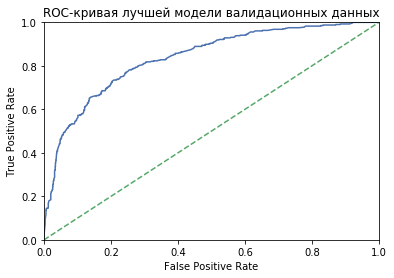

F1 наилучшей модели 'Случайный лес' на валидационной выборке: 0.5747800586510264 
AUC-ROC:  0.7690972945210233 
Depth:  4 
Number of estimators:  9 
Criterion:  entropy
CPU times: user 2.06 s, sys: 0 ns, total: 2.06 s
Wall time: 2.08 s


In [42]:
%%time
best_model = None
best_result = 0
best_est = 0
best_auc = 0
criterions = ['gini', 'entropy']

for criterion in criterions:
    for est in range(1, 20):
        model = RandomForestClassifier(random_state=12345,
                                       max_depth=4,
                                       criterion=criterion,
                                       n_estimators=est, 
                                       class_weight='balanced')
        model.fit(features_train, target_train)
        f1_result = f1_score(target_valid, model.predict(features_valid))
        if f1_result > best_result:
            best_est = est
            best_model = model
            best_result = f1_result
            best_criterion = criterion
            best_auc = auc_roc

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая лучшей модели валидационных данных')
plt.show()

print("F1 наилучшей модели 'Случайный лес' на валидационной выборке:",
      best_result, '\nAUC-ROC: ', best_auc, '\nDepth: ', best_depth,
      '\nNumber of estimators: ', best_est, '\nCriterion: ', best_criterion)

In [43]:
print(f'Значение метрики F1 на тестовых данных: {f1_score(target_test, best_model.predict(features_test))}')
print(f'AUC-ROC на тестовых данных: {roc_auc_score(target_test, best_model.predict_proba(features_test)[:, 1])}')

Значение метрики F1 на тестовых данных: 0.61003861003861
AUC-ROC на тестовых данных: 0.8568270272933294


# Вывод

Наивысшее значение метрики F1 получено на модели **Случайный лес** с глубиной 4 и количеством деревьев 10. 

Text(0, 0.5, 'Фактор')

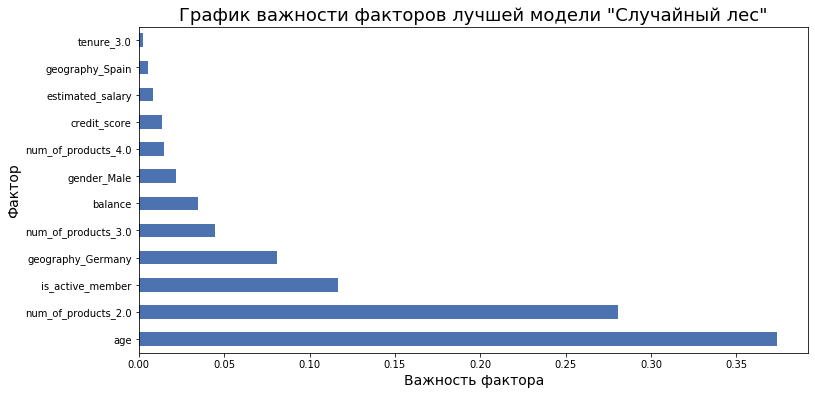

In [46]:
feat_importances = pd.Series(best_model.feature_importances_, index=features_test.columns)
plot = feat_importances.nlargest(12).plot(kind='barh', figsize=(12, 6))
plot.axes.set_title('График важности факторов лучшей модели "Случайный лес"', fontsize=18)
plot.set_xlabel('Важность фактора', fontsize=14)
plot.set_ylabel('Фактор', fontsize=14)
